# Final-Project
## Ankit Kumar Gautam 
## <u> Topic- LEIS Peak Fitting</u>

# <div align="center">Introduction</div>

## Motivation

A researcher working in Prof. Gellman's group is working on high-throughput experiments. Currently for data analysis he uses commercial software for LEIS spectrum peak fitting which is slow and hinders his research efforts. Also, the large amount of data generated from such experiments makes data organisation a difficult task. A need for a faster analysis is present. An added convenience for his lab colleagues would be having the possibility of viewing generated graphs/results later without re-running the entire code. 



## LEIS experiments
LEIS experiments aim to determine surface composition by measuring the energy from ions that are scattered from the surface. For heterogeneous catalysis, surface composition identification becomes an essential because reactions take place on surfaces and surface characterization is important for design of industrial catalysts. [Ref 1](https://doi.org/10.1016/j.cattod.2008.10.012)

Below attached is a sample data export available by plotting the data.

<img src="https://docs.google.com/uc?export=download&id=1v8XyIg573W5dAOgozVB33b1T66_eBGQ8" alt="LEIS Spectrum"
	title="A Typical graph from LEIS spectrum" width="400" />
    

Thus the aim of this project is to be able to pick a point within the 13x13 grid and get its data along with fitted peak and parameter

# <div align="center">Methods</div>

## Notebook Outline
The above task is completed in parts. Narrative text around the code cells are present to make the notebook more descriptive. The overall structure of this notebook is described as follows:

1. Read excel file containing data
2. Fit the data and write fitted data to a text file to avoid multiple fitting
3. Plot the scatter grid point and subsequent plots


The code starts with importing relevant libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

import ujson
from scipy.signal import find_peaks

# Used to read excel file
from openpyxl import load_workbook

# Used for non-linear fitting
from lmfit import Model

# Used for interactive graph
import plotly.graph_objects as go
from ipywidgets import widgets

## Reading Data
### Data structure

The data comes from 13x13 grid point sources, each giving out 481 KE energies. The grid points are conveniently labeled as 13 X points for each 13 Y points. The following screenshot aims to give a small glimpse of the data file.

<img src="http://drive.google.com/uc?export=view&id=1Cm5kLtYoIY5HCH4eNIKI1kgtyTwafpYJ" alt="Excel file Sample" width="600"/>

You may download the data files one of the following links 

- [500 K LEIS 1st round 27.5.xlsx](https://cmu.box.com/s/4j8b6q830qtpdjb3bbxlo214cehsje9r)
- [500 K LEIS 2nd round 27.5.xlsx](https://cmu.box.com/s/wrrrfivpafhgnxw3d2jg7qtm3cx1abna)
- [400 K LEIS 27.5.xlsx](https://cmu.box.com/s/2lre0lw3k3ucn0emuxaektrzfljak69n)

Run the following code to check if you do have at least one of the .xlsx file in place

In [2]:
! ls *.xlsx

400 K LEIS 27.5.xlsx
500 K LEIS 1st round 27.5.xlsx
500 K LEIS 2nd round 27.5.xlsx
600 K LEIS 1st round 27.5.xlsx
600 K LEIS 2nd round 27.5.xlsx
continuous LEIS on 2nd pt Cu 400 K Ankit.xlsx
continuous LEIS on 2nd pt Cu 400K-600K ramp.xlsx


The following cell declares the name of the file used for current analysis. Note this is the only input required from user.

In [3]:
excel_file = '500 K LEIS 1st round 27.5.xlsx'

### `pandas` to read excel file

In [4]:
def read_data(filename):    
    """ 
    This function reads the above specified file and returns two numpy array
    which contain the x-data and y-data 

    filename: string, Excel file to be read

    """
    
    # Iterate over all X-values. Y-values are stored in colummns of particular worksheet
    for x in range(0,13):

        wb = load_workbook(filename)
        ws = wb[str(x)]

        # This position of metadata doesn't change its relative position from sheet-to-sheet
        n_energy = ws['D2'].value
        n_iter = ws['D5'].value
        Rows_to_Skip = 15

        # Rename columns
        column_names = [str(x) for x in range(0,n_iter)]
        column_names.insert(0,'nan')
        column_names.insert(0,'KE')

        # Read data using pandas
        df_data = pd.read_excel(io = filename,
                           sheet_name=x,
                           skiprows = Rows_to_Skip,
                           names = column_names,
                           index_col='KE'
                          )
        # Drop the second column as it is always supposed to be false
        df_data.drop(columns=df_data.columns[0],inplace=True)
        
        # Get x_data as the index 
        x_array = np.array(df_data.index).reshape(len(df_data.index),1)
        
        # If we encounter first sheet
        if x==0:
            y = df_data.to_numpy()
            
        # Stack with the cummulative y built till now
        else:
            y = np.hstack((y, df_data.to_numpy()))
            
    # Ideally x_array should be (481, 1), and y should be (481, 169)
    return x_array, y


# These variables are used subsequently in the code
x_data,y_data = read_data(excel_file)
x_data.shape,y_data.shape

((481, 1), (481, 169))

After running the above code cell we should have read `x_data` which is KE (eV) and `y_data` which is Counts (1/s). Having the x's and y's we can proceed to fitting.

## Peak Fitting

With the data prepared, it's time for fitting peaks on the data. The peaks spectra are conveniently fitted by the following functions

\begin{align*}
Gaussian &= \frac{A}{\sqrt{2}\pi \sigma} exp\Big({-\frac{(x-\mu)^2}{2\sigma^2}}\Big) \\
Lorentzian & = \frac{A}{\pi} \frac{\Gamma}{(x-x_0)^2 + (\Gamma /2 )^2}\\
\end{align*}

Or Voigt, which is essentially a combination of these two. 

Here $A$ represent amplitude of the spectrum, $\sigma$ or $\Gamma$ capture width, $x_0$ or $\mu$ represent peak position. The ultimate aim is to get out $\mu$ or $x_0$ from the data for curves which represent the data accurately.

For the purpose of peak fitting here, sum of Gaussian functions are used as defined below. The data consists combinations of a single, double or triple peaks in the data. Thus all three combinations are declared.

In [5]:
def gaussian(x, amp, cen, width):
    """1-d gaussian: gaussian(x, amp, cen, width)
    x: independent variable
    amp: amplitude/height of the curve
    cen: mean or peak position
    width: standard deviation/ spread of the curve
    """
    return (amp / (np.sqrt(2*np.pi) * width)) * np.exp(-(x-cen)**2 / (2*width**2))

def gauss2(x,a1,c1,w1,a2,c2,w2):
    """ For fitting two gaussian peaks """
    return gaussian(x,a1,c1,w1)+gaussian(x,a2,c2,w2)

def gauss3(x,a1,c1,w1,a2,c2,w2,a3,c3,w3):
    """ For fitting three gaussian peaks """
    return gaussian(x,a1,c1,w1)+gaussian(x,a2,c2,w2)+gaussian(x,a3,c3,w3)

A single spectra is plotted below. We see that among all the data with us, two individual data series is built by sum of three peaks. Those peaks are roughly constant across the dataset.

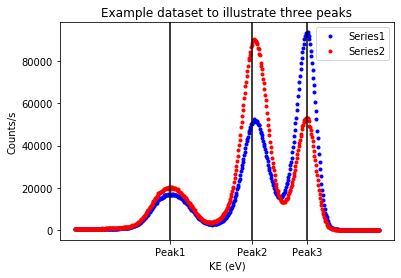

In [6]:
%matplotlib inline
plt.plot(x_data[:,0],y_data[:,70],'b.',label='Series1')
plt.plot(x_data[:,0],y_data[:,72],'r.',label='Series2')
plt.axvline(815,c='k')
plt.axvline(880,c='k')
plt.axvline(923,c='k')
plt.xticks([815, 880, 923], ['Peak1', 'Peak2', 'Peak3'])
plt.xlabel('KE (eV)')
plt.ylabel('Counts/s')
plt.legend()
plt.title('Example dataset to illustrate three peaks')
plt.savefig('two_spectra.png',dpi=300)

As marked in the above graphs, we need to identify if these three peaks are present. For such a non-linear fitting, we need to provide good estimates of $A$, $\mu$ and $\sigma$ to able to fit correctly. Estimates of amplitude can be kept same but the peaks positions are guessed by calling `scipy.signal_find_peaks`.

Briefly, `scipy.signal.find_peaks` is used to find the number of peaks and the peaks position. That many Gaussian functions are used to fit that particular `y` data. Initial estimates to the fitting profiles are provided by reading the source of that peak. After the fitting is done, the following items are prepared in a dictionary:

- Number of peaks
- `y` data
- `y1` (for 1 peak)
- `y1` and `y2` for two peaks
- `y1`, `y2` and `y3` for three peaks
- Fitted means of the peaks

The above data is written to a `json` file for faster reading during plotting. 

Following function reads x_data, y_data to find peaks and fit the data. It is only meant to be executed once for each corresponding excel file. User should change the name of the `json` file generated for each excel file.

In [ ]:
# No need to re-run this again if data.json is already built
def fit_and_write_json():
    """
    This function reads upon the excel file data and writes json file with fitted values
    """
    
    # Create a dictionary to store peaks for now
    data = {}
    
    height = []
    for i in range(169):
        peaks,_ = find_peaks(y_data[:,i],height=5000,distance=50)
        data[i] = np.array(peaks,dtype=float)
    
    # Currently the dictionary should look like {'1': 1, '2': 2, '3':2 ...} and so on
    peak_data = data
    
    # Iterating over all 13 X and 13 Ys
    
    for i in range(169):
        
        # If scipy.signal.find_peaks finds only one peak
        if len(peak_data[i]) == 1:
            gmodel = Model(gaussian)
            peak = x_data[int(peak_data[i][0])][0]
            
            # Initialize appropriate singal from the peak data
            # center "c1" comes from the peak data itself
            c1 = peak
            
            if peak <= 850:
                a1 = 10000
                w1 = 20
            elif peak <= 900:
                a1 = 40000
                w1 = 15
            else:
                a1 = 80000
                w1 = 10
                
            # Fit using these initial estimates
            result = gmodel.fit(y_data[:,i], x=x_data[:,0],amp=a1,cen=c1,width=w1)
            y1 = gaussian(x_data,result.best_values['amp'],result.best_values['cen'],result.best_values['width'])
            new_dict = {'peak':1,'y':y_data[:,i].tolist(),'fit':result.best_fit.tolist(),
                        'y1':y1.tolist(),'mu1':result.best_values['cen']}
            
        elif len(peak_data[i]) == 2:
            # For two peaks
            peak1 = x_data[int(peak_data[i][0])][0]
            peak2 = x_data[int(peak_data[i][1])][0]
            
            c1 = peak1
            c2 = peak2
            if peak1<= 850:
                a1 = 10000
                w1 = 20
            elif peak1 <= 900:
                a1 = 40000
                w1 = 15
            else:
                a1 = 80000
                w1 = 10
                
            if peak2<= 850:
                a2 = 10000
                w2 = 20
            elif peak2 <= 900:
                a2 = 40000
                w2 = 15
            else:
                a2 = 80000
                w2 = 10
            # Fit two peaks
            gmodel = Model(gauss2)
            result = gmodel.fit(y_data[:,i], x=x_data[:,0], a1 = a1,c1=c1,w1=w1,a2=a2,c2=c2,w2=w2)
            y1 = gaussian(x_data[:,0],result.best_values['a1'],result.best_values['c1'],result.best_values['w1'])
            y2 = gaussian(x_data[:,0],result.best_values['a2'],result.best_values['c2'],result.best_values['w2'])
            new_dict = {'peak':2,'y':y_data[:,i].tolist(),'fit':result.best_fit.tolist(),
                        'y1':y1.tolist(),'y2':y2.tolist(),
                        'mu1':result.best_values['c1'],'mu2':result.best_values['c2']}
            
        else:
            peak1 = x_data[int(peak_data[i][0])][0]
            peak2 = x_data[int(peak_data[i][1])][0]
            peak3 = x_data[int(peak_data[i][2])][0]
            
            c1 = peak1
            c2 = peak2
            c3 = peak3
            
            if peak1<= 850:
                a1 = 25000
                w1 = 20
            elif peak1 <= 900:
                a1 = 25000
                w1 = 15
            else:
                a1 = 25000
                w1 = 10
                
            if peak2<= 850:
                a2 = 25000
                w2 = 20
            elif peak2 <= 900:
                a2 = 25000
                w2 = 15
            else:
                a2 = 25000
                w2 = 10
                
            if peak3<= 850:
                a3 = 25000
                w3 = 20
            elif peak3 <= 900:
                a3 = 25000
                w3 = 15
            else:
                a3 = 25000
                w3 = 10                
            
            # Fit three peaks
            gmodel = Model(gauss3)
            result = gmodel.fit(y_data[:,i], x=x_data[:,0], a1 = a1,c1=c1,w1=w1,a2=a2,c2=c2,w2=w2,a3=a3,c3=c3,w3=w3)
            y1 = gaussian(x_data[:,0],result.best_values['a1'],result.best_values['c1'],result.best_values['w1'])
            y2 = gaussian(x_data[:,0],result.best_values['a2'],result.best_values['c2'],result.best_values['w2'])
            y3 = gaussian(x_data[:,0],result.best_values['a3'],result.best_values['c3'],result.best_values['w3'])
            new_dict = {'peak':3,'y':y_data[:,i].tolist(),'fit':result.best_fit.tolist(),'y1':y1.tolist(),
                        'y2':y2.tolist(),'y3':y3.tolist(),
                        'mu1':result.best_values['c1'],'mu2':result.best_values['c2'],
                        'mu3':result.best_values['c3']}
        peak_data[i] = new_dict
    
    
    # At this point all the fitting is completed
    # Write the data into a json file
    with open('data.json', 'w') as outfile:
        ujson.dump(peak_data, outfile)
    print(f'Fitting and Writing into a file done')

fit_and_write_json()

With the fit data ready, the plotting is done via `plotly` to have interactive nature.

In [7]:
%matplotlib notebook
# Make a grid of points from X and Y points
# These X and Y point remain same across all sheets
from itertools import product
all_grid=[]
for i,j in product(range(1,14),range(1,14)):
    all_grid.append([i,j])

grid_points = np.array(all_grid)

# Plot on grid points
xy_grid_plot = go.FigureWidget([go.Scatter(x=grid_points[:,0], y=grid_points[:,1], mode='markers')])
xy_grid_plot.update_layout(yaxis_tickformat = 'd',xaxis_title="X index", yaxis_title="Y index",)


# This code block gets markers of X and Y points
scatter = xy_grid_plot.data[0]
colors = ['#a3a7e4'] * len(all_grid)
scatter.marker.color = colors
scatter.marker.size = [10] * len(all_grid)
xy_grid_plot.layout.hovermode = 'closest'

with open('data.json') as json_file:
    peak_data = ujson.load(json_file)

# create our callback function
def update_point(trace, points, selector):
    
    # Get Color and size array
    c = list(scatter.marker.color)
    s = list(scatter.marker.size)
    
    # This figure_count makes sure only Two figures are plotted at one time
    figure_count = int(np.sum([1  for x in c if x=='#bae2be']))%3
        
    for i in points.point_inds:
    # Here i corresponds to clicked index of marker. It should be within {0,168}
        
        # When a new graphs needs to be added
        if c[i] == '#a3a7e4':
            new_color = np.array(c)
            new_color[i] = '#bae2be'
            new_size = np.array(s)
            new_size[i] = 20
            
        # When an old data needs to be removed. Marker is de-colorised but graph is not removed
        else:
            new_color = np.array(c)
            new_color[i] = '#a3a7e4'
            new_size = np.array(s)
            new_size[i] = 10
        
        # Update clicked marker
        with xy_grid_plot.batch_update():
            scatter.marker.color = new_color
            scatter.marker.size = new_size
            
        # Update graph corresponding to clicked index
        with main_plot.batch_update(): 
            j = str(i)
            x_ind = str(int(i/12))
            y_ind = str(i%12)
            #
            if peak_data[j]['peak'] ==1:            
                main_plot.data[5*figure_count+ 0].x = x_data[:,0]
                main_plot.data[5*figure_count+ 0].y = peak_data[j]['y']
                main_plot.data[5*figure_count+ 0].name = 'Data points X: ' + str(int(i/13) + 1 ) +', Y: ' + str(i%13 +1 )
                main_plot.data[5*figure_count+ 1].x = x_data[:,0]
                main_plot.data[5*figure_count+ 1].y = peak_data[j]['fit']
                main_plot.data[5*figure_count+ 1].name = 'Fit points X: ' + str(int(i/13) +1 )+', Y: ' + str(i%13 +1 )
                main_plot.data[5*figure_count+ 2].x = x_data[:,0]
                main_plot.data[5*figure_count+ 2].y = peak_data[j]['y1']
                main_plot.data[5*figure_count+ 2].name = ('Peak 1 for  X: ' + str(int(i/13) +1 ) +', Y: ' + str(i%13 +1 ) +
                                                        '\n mu1 = ' + f'{peak_data[j]["mu1"]:0.2f}' + ' eV')
                main_plot.data[5*figure_count+ 3].x = [900.0]
                main_plot.data[5*figure_count+ 3].y = [0.0]
                main_plot.data[5*figure_count+ 3].name = 'No Peak'
                main_plot.data[5*figure_count+ 4].x = [900.0]
                main_plot.data[5*figure_count+ 4].y = [0.0]
                main_plot.data[5*figure_count+ 4].name = 'No Peak'
            elif peak_data[j]['peak'] ==2:
                main_plot.data[5*figure_count+ 0].x = x_data[:,0]
                main_plot.data[5*figure_count+ 0].y = peak_data[j]['y']
                main_plot.data[5*figure_count+ 0].name = 'Data points X: ' + str(int(i/13) + 1 ) +', Y: ' + str(i%13 +1 )
                main_plot.data[5*figure_count+ 1].x = x_data[:,0]
                main_plot.data[5*figure_count+ 1].y = peak_data[j]['fit']
                main_plot.data[5*figure_count+ 1].name = 'Fit points X: ' + str(int(i/13) +1 )+', Y: ' + str(i%13 +1 )
                main_plot.data[5*figure_count+ 2].x = x_data[:,0]
                main_plot.data[5*figure_count+ 2].y = peak_data[j]['y1']
                main_plot.data[5*figure_count+ 2].name = ('Peak 1 for  X: ' + str(int(i/13) +1 ) +', Y: ' + str(i%13 +1 ) +
                                                        '\n mu1 = ' + f'{peak_data[j]["mu1"]:0.2f}'+ ' eV')
                main_plot.data[5*figure_count+ 3].x = x_data
                main_plot.data[5*figure_count+ 3].y = peak_data[j]['y2']
                main_plot.data[5*figure_count+ 3].name = ('Peak 2 for  X: ' + str(int(i/13) +1 ) +', Y: ' + str(i%13 +1 ) +
                                                        '\n mu2 = ' + f'{peak_data[j]["mu2"]:0.2f}'+ ' eV')
                main_plot.data[5*figure_count+ 4].x = [900.0]
                main_plot.data[5*figure_count+ 4].y = [0.0]
                main_plot.data[5*figure_count+ 4].name = 'No Peak'
            else:
                main_plot.data[5*figure_count+ 0].x = x_data[:,0]
                main_plot.data[5*figure_count+ 0].y = peak_data[j]['y']
                main_plot.data[5*figure_count+ 0].name = 'Data points X: ' + str(int(i/13) + 1 ) +', Y: ' + str(i%13 +1 )
                main_plot.data[5*figure_count+ 1].x = x_data[:,0]
                main_plot.data[5*figure_count+ 1].y = peak_data[j]['fit']
                main_plot.data[5*figure_count+ 1].name = 'Fit points X: ' + str(int(i/13) +1 )+', Y: ' + str(i%13 +1 )
                main_plot.data[5*figure_count+ 2].x = x_data[:,0]
                main_plot.data[5*figure_count+ 2].y = peak_data[j]['y1']
                main_plot.data[5*figure_count+ 2].name = ('Peak 1 for  X: ' + str(int(i/13) +1 ) +', Y: ' + str(i%13 +1 ) +
                                                        '\n mu1 = ' + f'{peak_data[j]["mu1"]:0.2f}'+ ' eV')
                main_plot.data[5*figure_count+ 3].x = x_data[:,0]
                main_plot.data[5*figure_count+ 3].y = peak_data[j]['y2']
                main_plot.data[5*figure_count+ 3].name = ('Peak 2 for  X: ' + str(int(i/13) +1 ) +', Y: ' + str(i%13 +1 ) +
                                                        '\n mu2 = ' + f'{peak_data[j]["mu2"]:0.2f}'+ ' eV')
                main_plot.data[5*figure_count+ 4].x = x_data[:,0]
                main_plot.data[5*figure_count+ 4].y = peak_data[j]['y3']
                main_plot.data[5*figure_count+ 4].name = ('Peak 3 for  X: ' + str(int(i/13) +1 ) +', Y: ' + str(i%13 +1 ) +
                                                        '\n mu3 = ' + f'{peak_data[j]["mu3"]:0.2f}'+ ' eV')
            
            
            main_plot.layout = go.Layout(title=dict(text='Reading Spectra from ' + excel_file))

                
                
scatter.on_click(update_point)

# Initialize First graphs
plot1 = go.Scatter(x=[900],y=[0],mode='markers',name='Data Points')
plot2 = go.Scatter(x=[900],y=[0],name='Fit',opacity=1)
plot3 = go.Scatter(x=[900],y=[0],name='Peak 1',fill='tozeroy',opacity=0.2,visible="legendonly")
plot4 = go.Scatter(x=[900],y=[0],name='Peak 2',fill='tozeroy',opacity=0.2,visible="legendonly")
plot5 = go.Scatter(x=[900],y=[0],name='Peak 3',fill='tozeroy',opacity=0.2,visible="legendonly")

# Initialize Second graphs
plot6 = go.Scatter(x=[900],y=[0],mode='markers',name='Data Points')
plot7 = go.Scatter(x=[900],y=[0],name='Fit',opacity=1)
plot8 = go.Scatter(x=[900],y=[0],name='Peak 1',fill='tozeroy',opacity=0.2,visible="legendonly")
plot9 = go.Scatter(x=[900],y=[0],name='Peak 2',fill='tozeroy',opacity=0.2,visible="legendonly")
plot10 = go.Scatter(x=[900],y=[0],name='Peak 3',fill='tozeroy',opacity=0.2,visible="legendonly")

# # Initialize Third graphs
# plot11 = go.Scatter(x=[900],y=[0],mode='markers',name='Data Points')
# plot12 = go.Scatter(x=[900],y=[0],name='Fit',opacity=1)
# plot13 = go.Scatter(x=[900],y=[0],name='Peak 1',fill='tozeroy',opacity=0.2,visible="legendonly")
# plot14 = go.Scatter(x=[900],y=[0],name='Peak 2',fill='tozeroy',opacity=0.2,visible="legendonly")
# plot15 = go.Scatter(x=[900],y=[0],name='Peak 3',fill='tozeroy',opacity=0.2,visible="legendonly")

main_plot = go.FigureWidget(data=[plot1,plot2,plot3,plot4,plot5,plot6,plot7,plot8,plot9,plot10],
                    layout=go.Layout(title=dict(text='LEIS Fitting Spectrum')))

main_plot .update_layout(yaxis_tickformat = 'd',xaxis_title="KE (eV)", yaxis_title="Counts/sec",)

z = widgets.VBox([xy_grid_plot,main_plot])
z

    'data': [{'marker': {'color': [#a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4, #a3a7e4,
…

The above interactive plot is able to show two clicked markers and their fitted lines from above grid. Clicks more than two are possible but the code will keep overwriting the previous graphs. The user is advised to remain cautious of this fact. Two graphs are chosen because more than two graphs makes the workspace messier and ugly to look at.

The code can be used to plot upto two graphs and their fits and subsequently export them using the code cell below.

In [ ]:
main_plot.write_html("LEIS_fitting.html",include_plotlyjs='cdn')

Above code cell will create a standalone HTML file which will have embedded the two data points series in it and shared among people without the need for this notebook from the creator.

# Conclusion

The final writing of the HTML file is a neat feature where the two embedded graphs can be shared without any external python/jupyter-notebook installation required by the reader.

This project can easily be extended to fit the kind of experiment data as well. For future uses, [Dash](https://dash.plotly.com/) can be developed to preserve the click interactive feature.